# TESTING THE EFFECT OF LUMINANCE ON PUPILOMETRY  - 6.25.24. Bryan Nathalia Test

## Imports

In [1]:
import pingouin as pg
import pyxdf
import cv2
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import pingouin as pg 
import seaborn as sns

In [3]:
xdf_path = "../Data/Pilots/luminance/sub-P001_ses-S001_task-Default_run-001_eyetracking.xdf"
data, header = pyxdf.load_xdf(xdf_path)
# List the streams
streams_collected = [stream['info']['name'][0] for stream in data]
print(streams_collected)
stim_data = data[0]
eye_data = data[1]

Stream 1: Calculated effective sampling rate 119.9949 Hz is different from specified rate 90.0000 Hz.


['Stimuli_Markers', 'Tobii']


# Attemping Time Synchronization

In [4]:
print(eye_data['footer']['info']['first_timestamp'][0])
#datetime.fromtimestamp(float(eye_data['footer']['info']['first_timestamp'][0]))
print(eye_data['time_stamps'][0])

2344383.020755
3035164.8920704434


In [5]:
x = eye_data['footer']['info']['clock_offsets'][0]
xx = x['offset']
float(xx[-1]['time'][0]) + float(xx[-1]['value'][0])

3035435.5768898

# Finding the TimeStamps for Stimulus Markers

In [6]:
events = pd.Series([x[0] for x in stim_data['time_series']], name='Event')
event_times = pd.Series([x for x in stim_data['time_stamps']], name='TimeStamp_original')
# Combining the two series into a DataFrame
stim_df = pd.concat([events, event_times], axis=1)
stim_df['lsl_time'] = stim_df['TimeStamp_original'].apply(lambda x: round(x, 2))
stim_df

,Event,TimeStamp_original,lsl_time
0,1,3.035179e+06,3035178.84
1,1721678425,3.035179e+06,3035178.84
2,2,3.035300e+06,3035299.85
3,1721678546,3.035300e+06,3035299.85
4,3,3.035420e+06,3035419.85
5,1721678666,3.035420e+06,3035419.85


We only care about events 1,2,3 as they correspond to the beginning , the switch, and the end

## Creating the EyeTracking Dataframe

In [7]:
# Get the column names
column_labels = [eye_data['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(eye_data['info']['desc'][0]['channels'][0]['channel']))]

eyes = pd.DataFrame(eye_data['time_series'], columns=column_labels)
# adding the the timestamps
eyes['lsl_time_og'] = eye_data['time_stamps']
eyes['lsl_time'] = eyes['lsl_time_og'].apply(lambda x: round(x, 2))

In [8]:
# Finding the indices for the start of the gray, switch, and green
gray_start_idx = eyes.loc[eyes.lsl_time == stim_df.loc[stim_df.Event == 1].lsl_time.values[0]].index[0]
switch_idx = eyes.loc[eyes.lsl_time == stim_df.loc[stim_df.Event == 2].lsl_time.values[0]].index[0]
green_end_idx = gray_start = eyes.loc[eyes.lsl_time == stim_df.loc[stim_df.Event == 3].lsl_time.values[0]].index[0]

# Splitting the data into the two conditions


In [9]:
eyes.loc[gray_start_idx:switch_idx, 'Condition'] = 'Gray'
eyes.loc[switch_idx:green_end_idx, 'Condition'] = 'Green'

# Adding the markers
eyes['stim_markers'] = False
eyes.loc[gray_start_idx, 'stim_markers'] = True
eyes.loc[switch_idx, 'stim_markers'] = True
eyes.loc[green_end_idx, 'stim_markers'] = True


## Left eye

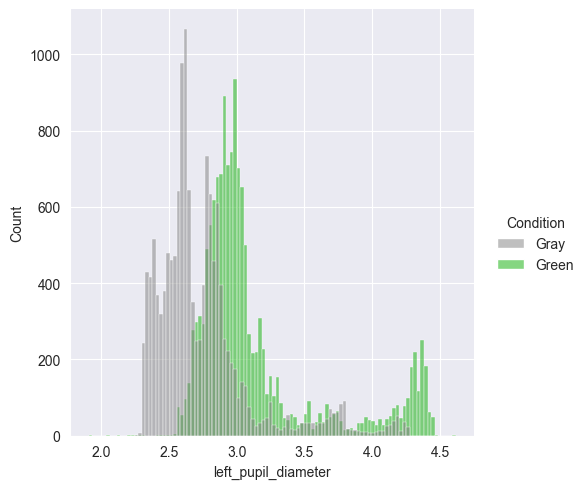

In [10]:
clr_palette = ['#808080', '#0CAF04']
sns.displot(data=eyes, x='left_pupil_diameter', hue='Condition', kind='hist', palette=clr_palette)

In [11]:
left_gray = eyes.loc[eyes.Condition== 'Gray', 'left_pupil_diameter'][::120]
left_green = eyes.loc[eyes.Condition== 'Green','left_pupil_diameter'][::120]
pg.ttest(left_gray[10:], left_green[10:]) # dropping the first 10 seconds

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.10646,204.736176,two-sided,1.939467e-11,"[-0.53, -0.3]",0.955896,4.439e+08,1.0


## Right eye

In [12]:
right_gray = eyes.loc[eyes.Condition== 'Gray', 'right_pupil_diameter'][::120]
right_green = eyes.loc[eyes.Condition== 'Green','right_pupil_diameter'][::120]
pg.ttest(right_gray[10:], right_green[10:])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.580231,220,two-sided,3.386802e-10,"[-0.44, -0.24]",0.883272,2.528e+07,0.999998


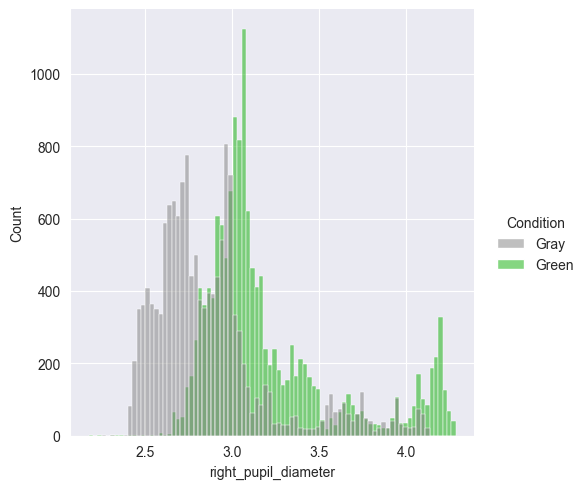

In [13]:
clr_palette = ['#808080', '#0CAF04']
sns.displot(data=eyes, x='right_pupil_diameter', hue='Condition', kind='hist', palette=clr_palette)

# Simulation

In [30]:
# Function to calculate luminance from RGB
def calculate_luminance(r, g, b):
    luminance = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return luminance

In [45]:
gray_luminance = calculate_luminance(128, 128, 128) 
green_luminance = calculate_luminance(11, 175, 10) 
print(gray_luminance)
print(green_luminance)

128.0
128.2206
